In [1]:
import os
import numpy as np
import pandas as pd
from Bio import SeqIO
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch
import mpl_stylesheet
import re
import gc
# mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 20, colors = 'banskt', dpi = 300)

In [2]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

fullmodel = T5ForConditionalGeneration.from_pretrained("models/prottrans_t5_xl_u50/").to(device)

fullmodel.full() if str(device)=='cpu' else fullmodel.half()

# Load the tokenizer
tokenizer = T5Tokenizer.from_pretrained('models/prottrans_t5_xl_u50', do_lower_case=False, legacy=False)


/usr/users/fsimonetti/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/users/fsimonetti/miniconda3/lib/python3.10/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [3]:
torch.cuda.empty_cache()

In [4]:
def sequence_masker(seq, i, j, same_extra_token=False):
    masked_sequence_list = seq.split()
    token_num = 0
    if j<=i:
        print(f"index j={j} must be greater than i={i}")
        raise
    for x in range(i, j):
        if j > len(seq):
            break
        masked_sequence_list[x] = f"<extra_id_{token_num}>"
        if not same_extra_token:
            token_num += 1
    return " ".join(masked_sequence_list)

In [5]:
# Load one dataset

import json

disprot_file = "AF2_testset.json"
with open(disprot_file) as infmt:
    disprot_dict = json.load(infmt)

In [16]:
from tqdm import tqdm

#torch.backends.cuda.enable_flash_sdp(True)

protids = list(disprot_dict.keys())
loss_dict = dict()
predmatch_dict = dict()
mask_sizes = [1]
for test_prot in protids:
    print(test_prot)
    if test_prot not in predmatch_dict:
        predmatch_dict[test_prot] = dict()
    if test_prot not in loss_dict:
        loss_dict[test_prot] = dict()
    
    target_seq = disprot_dict[test_prot]['seq']
    input_seq = [" ".join(list(re.sub(r"[UZOB]", "X", target_seq)))]
    true_input = tokenizer(input_seq)
    true_tok = torch.tensor(true_input['input_ids']).to(device)

    for mask_size in mask_sizes:
        print(f"#### Mask size: {mask_size} ####")
               
        loss_sequence = list()
        match_sequence = list()
        for i in tqdm(range(len(target_seq)-mask_size+1)):

            masked_seq = [sequence_masker(input_seq[0], i, i+mask_size)]
            tmp = tokenizer(masked_seq)
            input_ids = torch.tensor(tmp['input_ids']).to(device)
            attention_mask = torch.tensor(tmp['attention_mask']).to(device)
            with torch.no_grad():
                emb  = fullmodel(input_ids=input_ids, labels=true_tok)
                loss = emb.loss.cpu()
                loss_sequence.append(loss.item())
                cpulogits = emb.logits.cpu()
                fastpred = tokenizer.decode(torch.tensor(cpulogits[:,:-1,:].numpy().argmax(-1)[0]), skip_special_tokens=False).replace("<"," <").replace(">","> ")
    #             outputs = fullmodel.generate(input_ids=input_ids, max_length=input_ids.shape[1]+10)
    #             prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
    #             if fastpred == prediction:
    #                 print("OK ", end=" ")
                if input_seq[0] == fastpred:
                    match_sequence.append(True)
                else:
                    pred_arr = fastpred.split()
                    seq_arr  = input_seq[0].split()
                    if len(pred_arr) == len(seq_arr):
                        local_match_sequence = list()
                        for j in range(len(pred_arr)):
                            if pred_arr[j] != seq_arr[j]:
                                local_match_sequence.append((j,pred_arr[j], seq_arr[j]))
                    else:
                        print("Mismatch length error")
                        raise
                    match_sequence.append(local_match_sequence)
        predmatch_dict[test_prot][f"aa{mask_size}_match"] = match_sequence
        
        loss_dict[test_prot][f"aa{mask_size}_loss"] = loss_sequence
        torch.cuda.empty_cache()

# P37840
# #### Mask size: 1 ####
# 100%|███████████████████████████████████████████████████████████████████████| 140/140 [00:09<00:00, 15.54it/s]
# P04637
# #### Mask size: 1 ####
# 100%|███████████████████████████████████████████████████████████████████████| 393/393 [00:35<00:00, 11.20it/s]
# P02686
# #### Mask size: 1 ####
# 100%|███████████████████████████████████████████████████████████████████████| 304/304 [00:21<00:00, 14.23it/s]
# P07305
# #### Mask size: 1 ####
# 100%|███████████████████████████████████████████████████████████████████████| 194/194 [00:12<00:00, 14.96it/s]
# O00488
# #### Mask size: 1 ####
# 100%|███████████████████████████████████████████████████████████████████████| 134/134 [00:08<00:00, 15.29it/s]
# Q9NYB9
# #### Mask size: 1 ####
# 100%|███████████████████████████████████████████████████████████████████████| 513/513 [01:11<00:00,  7.22it/s]
# P06401
# #### Mask size: 1 ####
# 100%|███████████████████████████████████████████████████████████████████████| 933/933 [05:52<00:00,  2.65it/s]
# Q16186
# #### Mask size: 1 ####
# 100%|███████████████████████████████████████████████████████████████████████| 407/407 [00:36<00:00, 11.01it/s]
# S6B291
# #### Mask size: 1 ####
# 100%|███████████████████████████████████████████████████████████████████████| 466/466 [00:52<00:00,  8.84it/s]
# P23441
# #### Mask size: 1 ####
# 100%|███████████████████████████████████████████████████████████████████████| 372/372 [00:29<00:00, 12.51it/s]

P37840
#### Mask size: 1 ####


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:12<00:00, 11.21it/s]


P04637
#### Mask size: 1 ####


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 393/393 [00:41<00:00,  9.40it/s]


P02686
#### Mask size: 1 ####


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 304/304 [00:29<00:00, 10.45it/s]


P07305
#### Mask size: 1 ####


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 194/194 [00:17<00:00, 10.85it/s]


O00488
#### Mask size: 1 ####


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:11<00:00, 11.23it/s]


Q9NYB9
#### Mask size: 1 ####


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 513/513 [01:15<00:00,  6.83it/s]


P06401
#### Mask size: 1 ####


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 933/933 [05:17<00:00,  2.94it/s]


Q16186
#### Mask size: 1 ####


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 407/407 [00:45<00:00,  8.86it/s]


S6B291
#### Mask size: 1 ####


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 466/466 [01:00<00:00,  7.73it/s]


P23441
#### Mask size: 1 ####


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 372/372 [00:36<00:00, 10.17it/s]


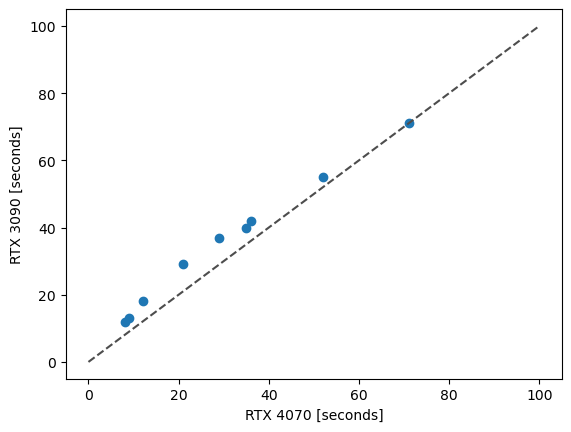

In [15]:
rtx4070 = [9,35,21,12,8,71,36,52,29]#5*60+52]

rtx3090_at_250w = [13,40,29,18,12,71,42,55,37]#,4*60+37]

rtx3090_at_220w = [12,41,29,17,11,75,42,55,37]#,4*60+37]


import matplotlib.pyplot as plt

plt.scatter(rtx4070, _at_250w_at_250w)
plt.plot([0, 100], [0, 100], ls="--", c=".3")
plt.ylabel("RTX 3090 [seconds]")
plt.xlabel("RTX 4070 [seconds]")
plt.show()

In [ ]:
monomer_file = "monomer_datadict.json"
with open(monomer_file) as infmt:
    monomer_dict = json.load(infmt)

In [ ]:
protids = list(monomer_dict.keys())
loss_dict = dict()
predmatch_dict = dict()
mask_sizes = [1, 5]
for test_prot in protids:
    print(test_prot)
    if test_prot not in predmatch_dict:
        predmatch_dict[test_prot] = dict()
    if test_prot not in loss_dict:
        loss_dict[test_prot] = dict()
    
    target_seq = monomer_dict[test_prot]['seq']
    input_seq = [" ".join(list(re.sub(r"[UZOB]", "X", target_seq)))]
    true_input = tokenizer(input_seq)
    true_tok = torch.tensor(true_input['input_ids']).to(device)

    for mask_size in mask_sizes:
        print(f"#### Mask size: {mask_size} ####")
               
        loss_sequence = list()
        match_sequence = list()
        for i in tqdm(range(len(target_seq)-mask_size+1)):

            masked_seq = [sequence_masker(input_seq[0], i, i+mask_size)]
            tmp = tokenizer(masked_seq)
            input_ids = torch.tensor(tmp['input_ids']).to(device)
            attention_mask = torch.tensor(tmp['attention_mask']).to(device)
            with torch.no_grad():
                emb  = fullmodel(input_ids=input_ids, labels=true_tok)
                loss = emb.loss.cpu()
                loss_sequence.append(loss.item())
                cpulogits = emb.logits.cpu()
                fastpred = tokenizer.decode(torch.tensor(cpulogits[:,:-1,:].numpy().argmax(-1)[0]), skip_special_tokens=False).replace("<"," <").replace(">","> ")
                if input_seq[0] == fastpred:
                    match_sequence.append(True)
                else:
                    pred_arr = fastpred.split()
                    seq_arr  = input_seq[0].split()
                    if len(pred_arr) == len(seq_arr):
                        local_match_sequence = list()
                        for j in range(len(pred_arr)):
                            if pred_arr[j] != seq_arr[j]:
                                local_match_sequence.append((j,pred_arr[j], seq_arr[j]))
                    else:
                        print("Mismatch length error")
                        raise
                    match_sequence.append(local_match_sequence)
        predmatch_dict[test_prot][f"aa{mask_size}_match"] = match_sequence
        
        loss_dict[test_prot][f"aa{mask_size}_loss"] = loss_sequence
        torch.cuda.empty_cache()


    
# with open("monomer_multi_loss.json", 'w') as outfmt:
#     json.dump(loss_dict, outfmt)
# with open("monomer_multi_mismatch.json", 'w') as outfmt:
#     json.dump(predmatch_dict, outfmt)